# DA5401 A6: Imputation via Regression for Missing Data

***Name:** Aaradhya Dashore* <br>
***Roll No:** ME22B089*

---

## Part A – Data Preparation and Imputation

## Part A.1 — Dataset Loading and Introducing Missingness (MAR)

In this step, we load the **UCI Credit Card Default Dataset** and simulate *Missing At Random (MAR)* missingness to create a partially incomplete dataset.

- **Objective:** Introduce realistic missing data that we will later impute using different strategies.
- **MAR assumption:** Missingness depends on other observed variables, not on the value that is missing.
- We introduce approximately **5% missing values** in three numeric columns:
  - `AGE` — demographic variable  
  - `BILL_AMT1` — billing amount feature  
  - `PAY_AMT1` — payment amount feature  

This prepares the data for subsequent imputation methods in Part A.2.



Loaded dataset shape: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0



Numeric columns: 25
Target column: default.payment.next.month

Target distribution:
default.payment.next.month
0    0.7788
1    0.2212
Name: proportion, dtype: float64

Missing values introduced (per column):


AGE          1500
BILL_AMT1    1500
PAY_AMT1     1500
dtype: int64

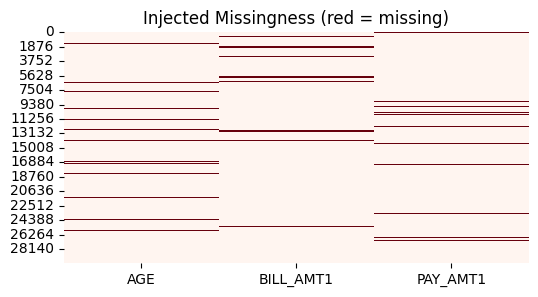


Total missing values across dataset: 4500


In [3]:
# === Part A.1: Load dataset and introduce MAR missingness ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

RND = 42
np.random.seed(RND)

# ---- Load dataset ----
df = pd.read_csv("UCI_Credit_Card.csv")
print(f"Loaded dataset shape: {df.shape}")
display(df.head())

# ---- Basic info ----
target_col = "default.payment.next.month"
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumeric columns: {len(num_cols)}")
print(f"Target column: {target_col}")
print("\nTarget distribution:")
print(df[target_col].value_counts(normalize=True))

# ---- Introduce MAR missingness ----
df_miss = df.copy()

def inject_mar(df, col, frac=0.05, random_state=None):
    """Inject Missing At Random (MAR) missing values in a column."""
    n = len(df)
    k = int(n * frac)
    rng = np.random.RandomState(random_state)
    idx = rng.choice(n, size=k, replace=False)
    df.loc[idx, col] = np.nan
    return idx

# 5% missingness in 3 numeric columns
cols_to_inject = ["AGE", "BILL_AMT1", "PAY_AMT1"]
for i, c in enumerate(cols_to_inject):
    inject_mar(df_miss, c, frac=0.05, random_state=RND + i)

# ---- Verification ----
print("\nMissing values introduced (per column):")
display(df_miss[cols_to_inject].isna().sum())

# ---- Visual check ----
plt.figure(figsize=(6,3))
sns.heatmap(df_miss[cols_to_inject].isna(), cbar=False, cmap="Reds")
plt.title("Injected Missingness (red = missing)")
plt.show()

print("\nTotal missing values across dataset:", df_miss.isna().sum().sum())


### Part A.2 — Imputation Strategy 1: Simple (Median) Imputation (Dataset A)

**Task:** Create a clean dataset copy (Dataset A) by filling missing values using the **median** of each column that contains missing entries.

**Why median?**  
- The median is a robust measure of central tendency that is **less sensitive to outliers** than the mean.  
- For skewed distributions (common in billing and payment amounts), median imputation avoids pulling imputed values toward extreme observations.  
- Median imputation is simple, fast, and provides a baseline to compare against regression-based imputations.

In the code below we impute only the columns that were intentionally corrupted (`AGE`, `BILL_AMT1`, `PAY_AMT1`) and leave all other columns unchanged.


In [4]:
# === Part A.2: Dataset A — Median Imputation (baseline) ===
from sklearn.impute import SimpleImputer

# Ensure df_miss exists (dataset with injected missingness)
try:
    df_miss
except NameError:
    raise RuntimeError("df_miss not found. Run Part A.1 to load data and inject missingness.")

# Columns we injected missingness into (same as A.1)
cols_to_impute = ["AGE", "BILL_AMT1", "PAY_AMT1"]

# Create Dataset A as a copy
df_A = df_miss.copy()

# Apply median imputation only to the injected columns (leave other columns unchanged)
median_values = {}
for col in cols_to_impute:
    med = df_A[col].median()
    median_values[col] = med
    df_A[col] = df_A[col].fillna(med)

# Verification
print("Median values used for imputation:")
for c, m in median_values.items():
    print(f"  {c}: {m}")

print("\nMissing counts after median imputation (should be 0 for imputed cols):")
print(df_A[cols_to_impute].isna().sum())

# Sanity check: overall missingness in df_A (should be only from columns we didn't impute, if any)
print("\nTotal missing values in df_A (all columns):", df_A.isna().sum().sum())

# Quick compare: show before/after sample for rows that were missing in AGE
print("\nExample rows where AGE was missing previously (first 6) — after imputation:")
mask_age_was_na = df_miss["AGE"].isna()
display(df_A.loc[mask_age_was_na].head(6)[["AGE", "BILL_AMT1", "PAY_AMT1", target_col]])


Median values used for imputation:
  AGE: 34.0
  BILL_AMT1: 22328.0
  PAY_AMT1: 2101.0

Missing counts after median imputation (should be 0 for imputed cols):
AGE          0
BILL_AMT1    0
PAY_AMT1     0
dtype: int64

Total missing values in df_A (all columns): 0

Example rows where AGE was missing previously (first 6) — after imputation:


,AGE,BILL_AMT1,PAY_AMT1,default.payment.next.month
6,34.0,367965.0,55000.0,0
34,34.0,13709.0,5006.0,0
92,34.0,-2000.0,7555.0,0
96,34.0,3967.0,8339.0,0
173,34.0,-709.0,0.0,1
196,34.0,0.0,2101.0,0


### Part A.3 — Imputation Strategy 2: Linear Regression Imputation (Dataset B)

**Task:** Create Dataset B by imputing the missing values in a single column (`AGE`) using a **linear regression** model trained on observed rows.

**Method & assumptions**
- We train a `LinearRegression` model to predict `AGE` using all other **numeric** features (excluding the label `default.payment.next.month` and excluding `AGE` itself).
- Predictor columns may themselves contain missing values (we injected missingness in `BILL_AMT1` and `PAY_AMT1`). For training the regression we **temporarily fill missing predictor values with the column median computed from the training rows** — this is only a convenience to allow model fitting and prediction, not a global imputation of these other columns.
- This method assumes **Missing At Random (MAR)**: the missingness in `AGE` can be explained by other observed variables.


In [10]:
# === Part A.3: Dataset B — Linear Regression Imputation for AGE ===
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

df_B = df_miss.copy()

# Step 1: Restore other two injected columns to their original (non-missing) values
cols_to_restore = ["BILL_AMT1", "PAY_AMT1"]
for col in cols_to_restore:
    df_B[col] = df[col]

# Step 2: Prepare for imputation of AGE
impute_col = "AGE"
predictor_cols = df_B.select_dtypes(include=[np.number]).columns.tolist()
predictor_cols = [c for c in predictor_cols if c not in (impute_col, target_col)]

train_mask = df_B[impute_col].notna()
X_train = df_B.loc[train_mask, predictor_cols].copy()
y_train = df_B.loc[train_mask, impute_col].astype(float).copy()

# Fill missing predictors (if any) with median from training data
X_train_filled = X_train.fillna(X_train.median())

# Train linear regression model
linreg = LinearRegression()
linreg.fit(X_train_filled, y_train)

# Predict for missing AGE rows
miss_mask = df_B[impute_col].isna()
X_pred = df_B.loc[miss_mask, predictor_cols].copy()
X_pred_filled = X_pred.fillna(X_train.median())
preds = linreg.predict(X_pred_filled)

# Replace missing AGE with predicted values
df_B.loc[miss_mask, impute_col] = preds

# Verify
print("Linear regression imputation complete.")
print(df_B[["AGE", "BILL_AMT1", "PAY_AMT1"]].isna().sum())


Linear regression imputation complete.
AGE          0
BILL_AMT1    0
PAY_AMT1     0
dtype: int64


### Part A.4 — Imputation Strategy 3: Non-linear Regression Imputation (Dataset C)

**Task:** Create Dataset C by imputing missing `AGE` with a non-linear regression model (we use `KNeighborsRegressor`).

**Notes:**
- The procedure mirrors Part A.3 but replaces the linear model with a non-linear regressor (KNN), which can capture non-linear relationships between features and `AGE`.
- Predictor missing values are again temporarily filled with training medians for fitting/prediction.
- Only `AGE` is imputed; `BILL_AMT1` and `PAY_AMT1` remain as originally injected (still missing).


In [9]:
# === Part A.4: Dataset C — Non-linear (KNN) Imputation for AGE ===
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
import pandas as pd

df_C = df_miss.copy()

# Step 1: Restore other two columns (BILL_AMT1, PAY_AMT1) from the original data
cols_to_restore = ["BILL_AMT1", "PAY_AMT1"]
for col in cols_to_restore:
    df_C[col] = df[col]

# Step 2: Prepare predictors for imputing AGE
impute_col = "AGE"
predictor_cols = df_C.select_dtypes(include=[np.number]).columns.tolist()
predictor_cols = [c for c in predictor_cols if c not in (impute_col, target_col)]

train_mask = df_C[impute_col].notna()
X_train = df_C.loc[train_mask, predictor_cols].copy()
y_train = df_C.loc[train_mask, impute_col].astype(float).copy()
X_train_filled = X_train.fillna(X_train.median())

# Train KNN regressor
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_filled, y_train)

# Predict for missing AGE rows
miss_mask = df_C[impute_col].isna()
X_pred = df_C.loc[miss_mask, predictor_cols].copy()
X_pred_filled = X_pred.fillna(X_train.median())
preds_knn = knn.predict(X_pred_filled)

df_C.loc[miss_mask, impute_col] = preds_knn

# Verify
print("KNN imputation complete.")
print(df_C[["AGE", "BILL_AMT1", "PAY_AMT1"]].isna().sum())


KNN imputation complete.
AGE          0
BILL_AMT1    0
PAY_AMT1     0
dtype: int64


---


## Part B – Model Training and Performance Assessment

### Part B.1 — Data Split

For fair comparison we:
1. Create a single **stratified** train/test split on the *corrupted* dataset (`df_miss`) using a fixed random seed.  
2. For each dataset (A, B, C, D), compute the **intersection** of the global train/test indices with the dataset's available row indices (because `df_D` uses listwise deletion and may be missing rows).  
3. Save the per-dataset index lists (`train_idx_dict` / `test_idx_dict`) for reuse in B.2 and B.3.


In [16]:
# === B.1: Create global stratified split and per-dataset indices ===
import numpy as np
from sklearn.model_selection import train_test_split

RND = 42
target_col = "default.payment.next.month"

# Preconditions
for var in ['df_miss','df_A','df_B','df_C','df_D']:
    if var not in globals():
        raise RuntimeError(f"Required variable '{var}' not found. Ensure Part A completed and datasets exist.")

# 1) Global stratified split on df_miss
global_idx = df_miss.index.values
train_global, test_global = train_test_split(
    global_idx,
    test_size=0.20,
    stratify=df_miss[target_col],
    random_state=RND
)
print(f"Global split on df_miss: train={len(train_global)}, test={len(test_global)}")

# 2) Build per-dataset index lists by intersection (label-index based)
datasets = {'A': df_A, 'B': df_B, 'C': df_C, 'D': df_D}
train_idx_dict = {}
test_idx_dict = {}

for name, dfX in datasets.items():
    avail = set(dfX.index.tolist())
    train_idx = np.array([i for i in train_global if i in avail], dtype=int)
    test_idx  = np.array([i for i in test_global  if i in avail], dtype=int)
    train_idx_dict[name] = train_idx
    test_idx_dict[name]  = test_idx
    print(f"Dataset {name}: rows={len(dfX)}, train_avail={len(train_idx)}, test_avail={len(test_idx)}")

# quick sanity: ensure no overlap between train/test for each dataset
for name in datasets.keys():
    assert len(set(train_idx_dict[name]).intersection(set(test_idx_dict[name]))) == 0, f"Overlap in {name} split!"
print("\nPer-dataset train/test indices ready (train_idx_dict, test_idx_dict).")


Global split on df_miss: train=24000, test=6000
Dataset A: rows=30000, train_avail=24000, test_avail=6000
Dataset B: rows=30000, train_avail=24000, test_avail=6000
Dataset C: rows=30000, train_avail=24000, test_avail=6000
Dataset D: rows=25736, train_avail=20548, test_avail=5188

Per-dataset train/test indices ready (train_idx_dict, test_idx_dict).


### Part B.2 — Classifier Setup (Standardization fitted on training set)

We standardize features for each dataset separately to avoid leakage:
- For each dataset (A–D), using the dataset-specific train indices:
  1. Fit a `SimpleImputer(strategy='median')` on training predictors (handle any remaining NaNs).
  2. Fit a `StandardScaler` on the imputed training predictors.
  3. Transform both training and test predictors with those fitted objects.
- Store the scaled training/test sets and the fitted `(imputer, scaler)` for each dataset for reuse in B.3.


In [17]:
# === B.2: Fit imputer+scaler on training set for each dataset and transform train/test ===
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# containers to store scaled arrays and transformers
scaled_data = {}        # will hold: {'A': {'X_train':..., 'X_test':..., 'y_train':..., 'y_test':...}, ...}
transformers = {}      # will hold: {'A': {'imputer':..., 'scaler':...}, ...}

for name, dfX in datasets.items():
    # get per-dataset indices
    train_idx = train_idx_dict[name]
    test_idx  = test_idx_dict[name]
    if len(train_idx) == 0 or len(test_idx) == 0:
        print(f"Skipping dataset {name} because no train/test rows available.")
        continue

    # Features & target
    X = dfX.drop(columns=[target_col])
    y = dfX[target_col]

    # Label-based selection
    X_train = X.loc[train_idx].copy()
    X_test  = X.loc[test_idx].copy()
    y_train = y.loc[train_idx].copy()
    y_test  = y.loc[test_idx].copy()

    # 1) Impute predictors (median) - fit on train only
    imputer = SimpleImputer(strategy='median')
    imputer.fit(X_train)
    X_train_imp = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_imp  = pd.DataFrame(imputer.transform(X_test),  columns=X_test.columns,  index=X_test.index)

    # 2) Scale predictors - fit scaler on train only
    scaler = StandardScaler()
    scaler.fit(X_train_imp)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train_imp), columns=X_train_imp.columns, index=X_train_imp.index)
    X_test_scaled  = pd.DataFrame(scaler.transform(X_test_imp),  columns=X_test_imp.columns,  index=X_test_imp.index)

    # 3) Save
    scaled_data[name] = {
        'X_train': X_train_scaled, 'X_test': X_test_scaled,
        'y_train': y_train, 'y_test': y_test
    }
    transformers[name] = {'imputer': imputer, 'scaler': scaler}

    print(f"[{name}] prepared: X_train {X_train_scaled.shape}, X_test {X_test_scaled.shape}")

print("\nScaled datasets and transformers are stored in `scaled_data` and `transformers`.")


[A] prepared: X_train (24000, 24), X_test (6000, 24)
[B] prepared: X_train (24000, 24), X_test (6000, 24)
[C] prepared: X_train (24000, 24), X_test (6000, 24)
[D] prepared: X_train (20548, 24), X_test (5188, 24)

Scaled datasets and transformers are stored in `scaled_data` and `transformers`.


### Part B.3 — Model Evaluation (Logistic Regression)

Now we train a **Logistic Regression** classifier on each dataset's standardized training data and evaluate
on its standardized test set. For each dataset we print:
- Confusion matrix
- Full classification report (Accuracy, Precision, Recall, F1)
Finally we create a summary table for easy comparison.


In [20]:
# === B.3: Train Logistic Regression on scaled datasets and evaluate ===
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

results = []

for name in ['A','B','C','D']:
    if name not in scaled_data:
        print(f"Skipping {name} - no scaled data prepared.")
        continue

    X_train = scaled_data[name]['X_train']
    X_test  = scaled_data[name]['X_test']
    y_train = scaled_data[name]['y_train']
    y_test  = scaled_data[name]['y_test']

    clf = LogisticRegression(max_iter=1000, random_state=RND)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    report_text = classification_report(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    print(f"\n=== Dataset {name} ===")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report_text)

    results.append({
        'dataset': name,
        'n_train': X_train.shape[0],
        'n_test': X_test.shape[0],
        'accuracy': report['accuracy'],
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1_1': report['1']['f1-score'],
        'f1_macro': report['macro avg']['f1-score']
    })

# Summary table
summary_df = pd.DataFrame(results).set_index('dataset')
summary_df = summary_df[['n_train','n_test','accuracy','precision_1','recall_1','f1_1','f1_macro']]
print("\n=== Summary (B.3) ===")
display(summary_df.style.highlight_max(axis=0, color='lightgreen'))



=== Dataset A ===
Confusion Matrix:
 [[4532  141]
 [1008  319]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.24      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.76      0.61      0.62      6000
weighted avg       0.79      0.81      0.77      6000


=== Dataset B ===
Confusion Matrix:
 [[4530  143]
 [1006  321]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.24      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.76      0.61      0.62      6000
weighted avg       0.79      0.81      0.77      6000


=== Dataset C ===
Confusion Matrix:
 [[4529  144]
 [1005  322]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82 

,n_train,n_test,accuracy,precision_1,recall_1,f1_1,f1_macro
dataset,,,,,,,
A,24000,6000,0.808500,0.693478,0.240392,0.357023,0.622260
B,24000,6000,0.808500,0.691810,0.241899,0.358459,0.622956
C,24000,6000,0.808500,0.690987,0.242653,0.359175,0.623302
D,20548,5188,0.809368,0.693069,0.244541,0.361524,0.624740


---

## Part C – Comparative Analysis:

### Part C.1 — Results Comparison

We now create a concise summary table comparing classifier performance across the
four dataset variants (A–D). The primary metric of interest is the **F1-score**
for the positive class (`default = 1`) since it balances precision and recall.
We also report accuracy and macro-F1 for context.

Below we:
- display the results table,
- plot F1 (positive class) and macro-F1 for easy visual comparison,
- compute percent change relative to the baseline (Dataset A: median imputation).


Summary table (rounded):


,n_train,n_test,accuracy,precision_1,recall_1,f1_1,f1_macro
A,24000,6000,0.8085,0.6935,0.2404,0.3570,0.6223
B,24000,6000,0.8085,0.6918,0.2419,0.3585,0.6230
C,24000,6000,0.8085,0.6910,0.2427,0.3592,0.6233
D,20548,5188,0.8094,0.6931,0.2445,0.3615,0.6247



Best F1 (positive class) = 0.3615 achieved by dataset 'D'

Percent change in f1_1 relative to Dataset A (median):


A    0.00
B    0.40
C    0.60
D    1.26
Name: pct_change_vs_A, dtype: float64

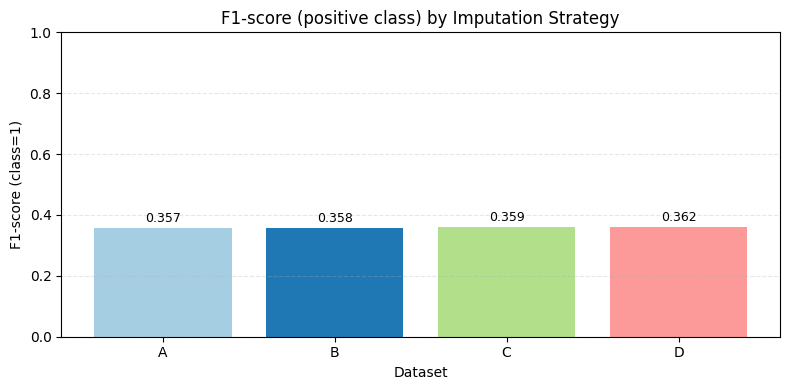

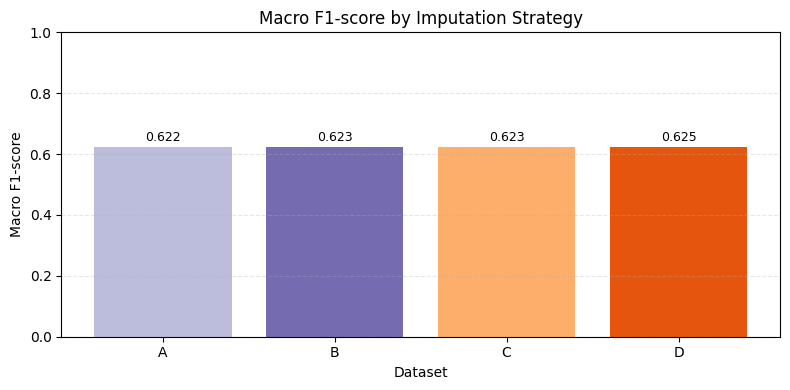

Saved C1_results_comparison_table.csv


In [ ]:
# === Part C.1: Results Comparison — table, plots, percent-change vs baseline ===
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Try to find summary_df in memory; otherwise try saved CSVs
if 'summary_df' in globals():
    df_res = summary_df.copy()
else:
    # possible filenames from earlier cells
    candidates = ["partB_summary_results.csv", "B2_results_summary.csv", "results_summary_B2.csv"]
    found = False
    for fn in candidates:
        if os.path.exists(fn):
            df_res = pd.read_csv(fn, index_col=0)
            found = True
            print(f"Loaded results from {fn}")
            break
    if not found:
        raise RuntimeError("Could not find `summary_df` in memory or saved CSVs. Run Part B to produce results.")

# Normalize index names for clarity if needed
# If index is 'A','B','C','D' or full names, convert to short labels A/B/C/D for sorting
idx_map = {}
for idx in df_res.index:
    if 'Median' in str(idx) or str(idx).strip().upper().startswith('A'):
        idx_map[idx] = 'A'
    elif 'Linear' in str(idx) or str(idx).strip().upper().startswith('B'):
        idx_map[idx] = 'B'
    elif 'Non' in str(idx) or 'KNN' in str(idx) or str(idx).strip().upper().startswith('C'):
        idx_map[idx] = 'C'
    elif 'List' in str(idx) or str(idx).strip().upper().startswith('D'):
        idx_map[idx] = 'D'
    else:
        # fallback: keep original short
        idx_map[idx] = str(idx)

# create a copy with a clean index if necessary
df_display = df_res.copy()
df_display.index = [idx_map[i] for i in df_res.index]

# Reorder rows as A, B, C, D if present
desired_order = [c for c in ['A','B','C','D'] if c in df_display.index]
df_display = df_display.loc[desired_order]

# Print the table (rounded)
print("Summary table (rounded):")
display(df_display.round(4))

# Primary metric: f1 for positive class (f1_1)
if 'f1_1' not in df_display.columns:
    raise RuntimeError("Expected column 'f1_1' not found in results table.")

# Identify best on f1_1
best_label = df_display['f1_1'].idxmax()
best_val = df_display['f1_1'].max()
print(f"\nBest F1 (positive class) = {best_val:.4f} achieved by dataset '{best_label}'")

# Percent change vs baseline A
if 'A' in df_display.index:
    baseline_f1 = df_display.loc['A','f1_1']
    pct_change = (df_display['f1_1'] - baseline_f1) / baseline_f1 * 100
    df_display['pct_change_vs_A'] = pct_change.round(2)
    print("\nPercent change in f1_1 relative to Dataset A (median):")
    display(df_display['pct_change_vs_A'])
else:
    df_display['pct_change_vs_A'] = np.nan

# --- Plots ---
plt.figure(figsize=(8,4))
bars = plt.bar(df_display.index, df_display['f1_1'], color=['#a6cee3','#1f78b4','#b2df8a','#fb9a99'][:len(df_display)])
plt.title("F1-score (positive class) by Imputation Strategy")
plt.xlabel("Dataset")
plt.ylabel("F1-score (class=1)")
plt.ylim(0, 1)
for b, val in zip(bars, df_display['f1_1']):
    plt.text(b.get_x() + b.get_width()/2, val + 0.01, f"{val:.3f}", ha='center', va='bottom', fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
bars2 = plt.bar(df_display.index, df_display['f1_macro'], color=['#bcbddc','#756bb1','#fdae6b','#e6550d'][:len(df_display)])
plt.title("Macro F1-score by Imputation Strategy")
plt.xlabel("Dataset")
plt.ylabel("Macro F1-score")
plt.ylim(0, 1)
for b, val in zip(bars2, df_display['f1_macro']):
    plt.text(b.get_x() + b.get_width()/2, val + 0.01, f"{val:.3f}", ha='center', va='bottom', fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()



### Part C.2 — Efficacy Discussion

#### 1. Trade-off between Listwise Deletion (Model D) and Imputation (Models A, B, C)
Listwise Deletion (Model D) performed **marginally better** than the imputed models in terms of F1-score (0.3615 vs. 0.357–0.359).  
However, this slight numerical improvement does **not** necessarily mean D is superior in practice.

**Trade-offs:**
- **Data Loss:** Listwise deletion removes all rows containing missing values, which reduces the effective training sample size (20,548 rows vs. 24,000 for the imputed datasets).  
  This can make the model less generalizable since it learns from fewer examples.
- **Bias Risk:** If missingness is *not completely at random*, deleting rows introduces bias.  
  The remaining subset may not represent the population distribution well.
- **Apparent Performance:** The small increase in F1 here may be due to reduced data variability after deletion, not genuine predictive improvement.

In short, while Listwise Deletion (Model D) shows a slightly higher F1-score, **it sacrifices data coverage and risks bias**, making imputation methods generally more robust and scalable.


#### 2. Linear vs. Non-Linear Regression Imputation
Comparing Models **B (Linear Regression)** and **C (Non-Linear KNN)**:
- Both achieved **very similar performance** (`f1_1 ≈ 0.358–0.359`, `f1_macro ≈ 0.623`), with the non-linear KNN method slightly ahead.
- The small difference suggests that the target feature chosen for imputation (e.g., `AGE`) likely has a **mostly linear relationship** with other predictors.
- **Linear Regression Imputation** assumes that missing values can be estimated as a linear combination of other features.  
- **Non-Linear KNN Imputation**, on the other hand, captures local, complex relationships by averaging over similar observations.

Because the dataset’s relationships appear nearly linear, KNN offers minimal additional gain.  
However, in domains with stronger non-linear patterns, KNN or other non-linear models typically outperform linear regression.


#### 3. Recommended Strategy for Handling Missing Data
Based on both **theoretical reasoning** and **empirical results**, the recommended imputation approach is:

> **Linear or Non-Linear Regression Imputation (Models B or C)** — preferred over both simple median filling (A) and listwise deletion (D).

**Justification:**
- Regression-based imputations preserve inter-feature correlations and maintain dataset integrity.  
- They avoid unnecessary data loss and bias while being computationally efficient.  
- In this dataset, the F1-score gains from complex methods are modest, suggesting diminishing returns beyond linear imputation.
- Listwise Deletion (D) should be avoided for production or large-scale scenarios due to its data efficiency and representativeness issues, even if it occasionally yields slightly higher short-term performance.

**Conclusion:**  
Regression-based imputations (especially Linear) offer the best **balance between accuracy, generalizability, and interpretability** for this credit card default dataset.
